In [1]:
import pandas as pd
from utils import *

In [2]:
# Load the beta skeleton adjacency matrix from CSV
df= pd.read_csv("../data/Dot pattern coordinates_version_0.csv")

In [3]:
df

,Dot Number,X,Y
0,1,150,300
1,2,170,280
2,3,190,270
3,4,210,275
4,5,230,290
...,...,...,...
58,59,670,610
59,60,650,590
60,61,630,570
61,62,610,550


In [4]:
coords = df[["X", "Y"]].values
names = df["Dot Number"].values

In [5]:

def plot_points(coords, names, etiquetas=True):
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.scatter(coords[:, 0], coords[:, 1], color='blue', s=50)
    texts = []
    if etiquetas:

        for i, (x, y) in enumerate(coords):
            texts.append(ax.text(x, y, names[i], fontsize=8))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    # ax.set_title("Pueblos: solo puntos")
    ax.axis("equal")
    ax.grid(True)

    adjust_text(
        texts,
        ax=ax,
        only_move={'points': 'y', 'texts': 'xy'},
        arrowprops=dict(
            arrowstyle='->',
            color='gray',
            lw=0.5,
            shrinkA=10
        ),
        expand_points=(1.2, 1.2),
        force_text=1.0,
        force_points=0.2
    )

    plt.show()

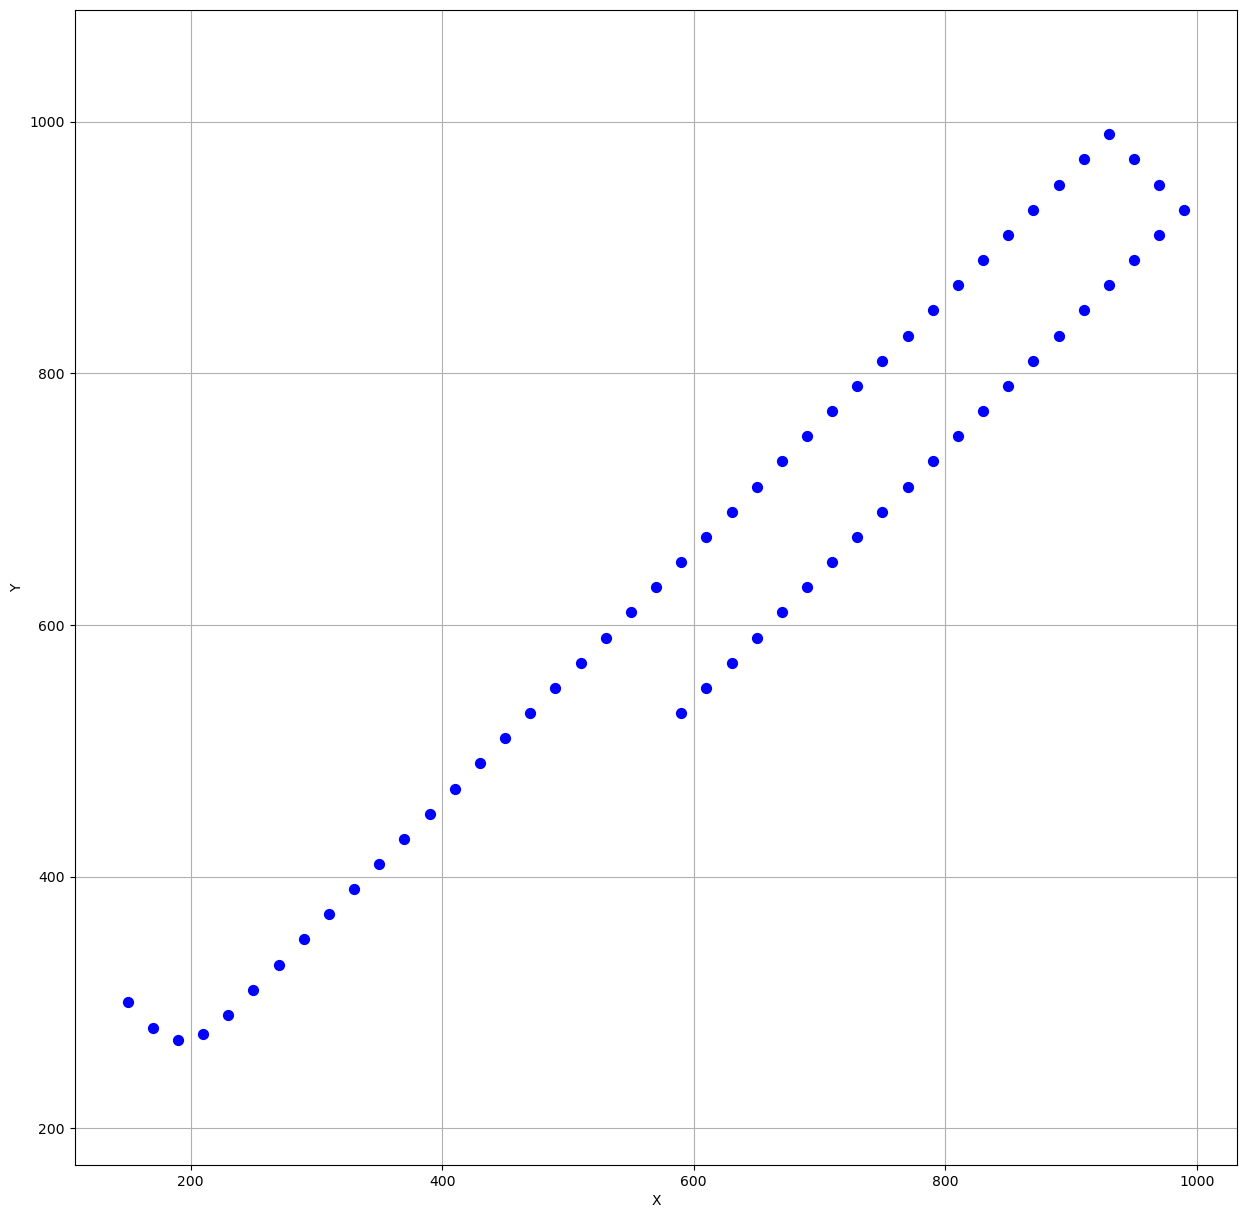

In [6]:
plot_points(coords, names, etiquetas=False)

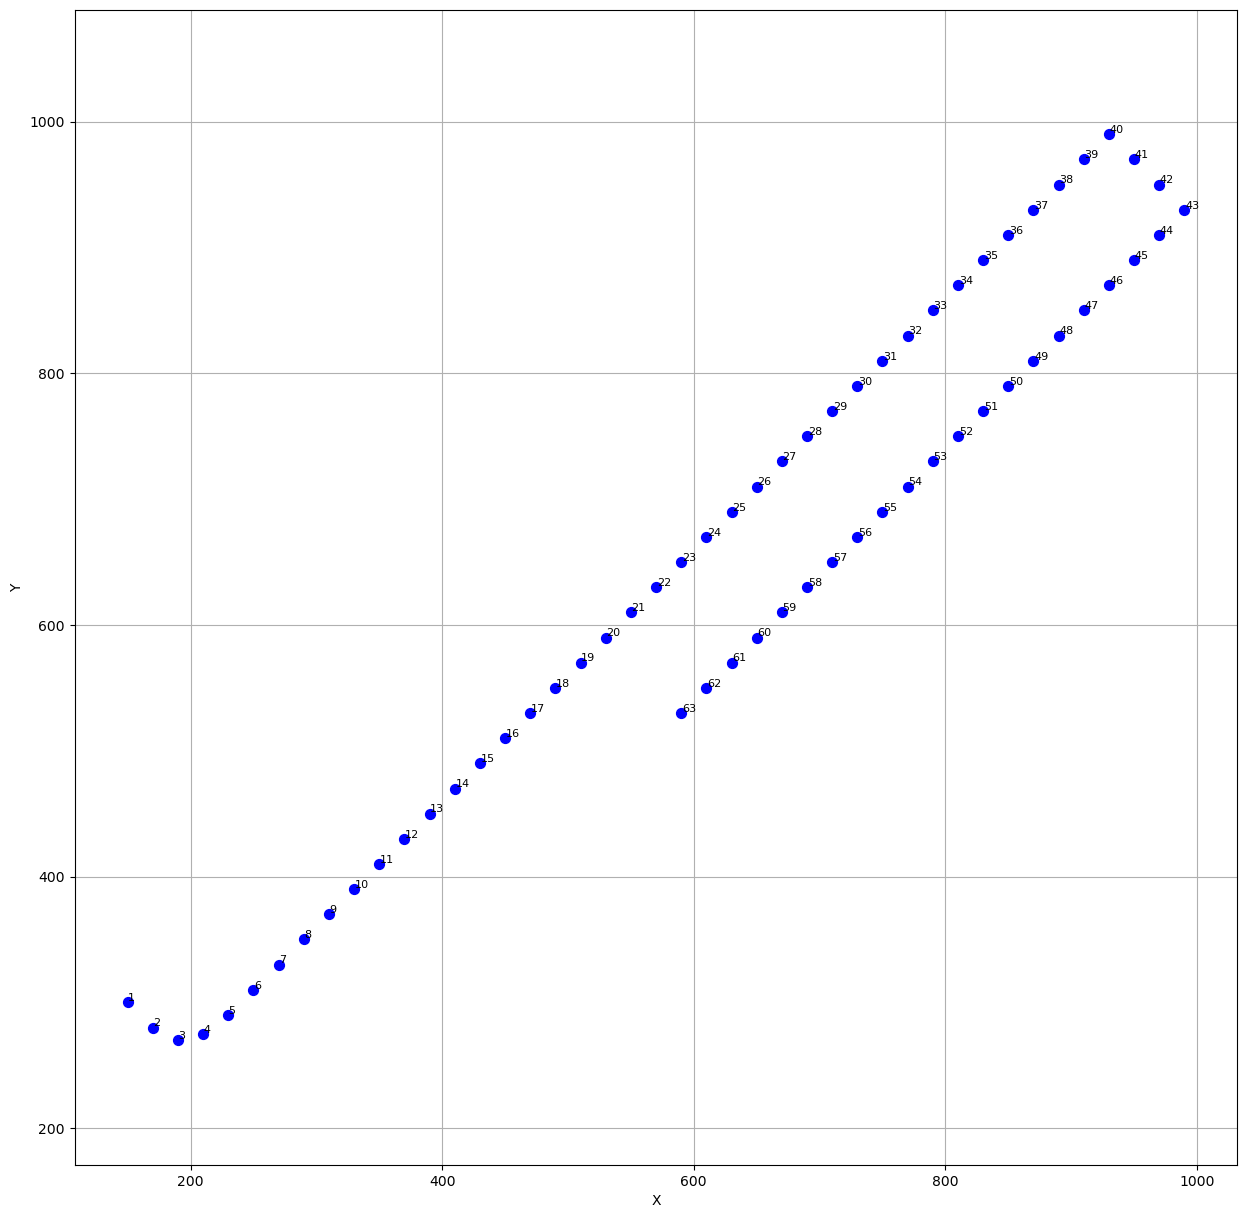

In [7]:
plot_points(coords, names, etiquetas=True)

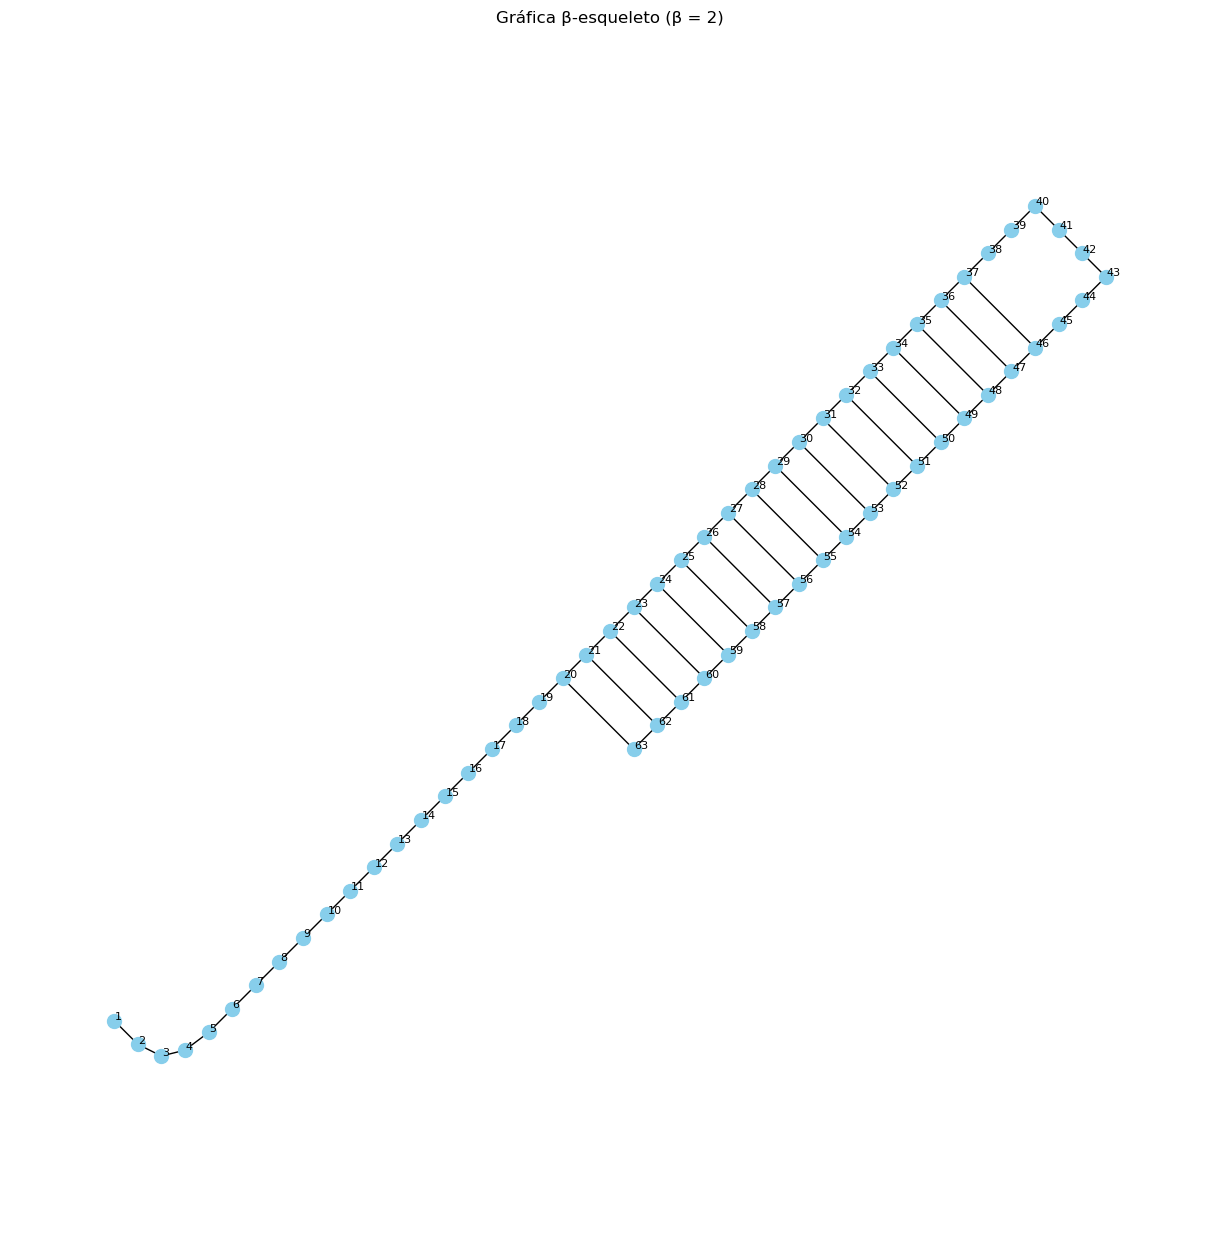

In [8]:
plot_beta_skeleton_graph(coords, names, beta=2)

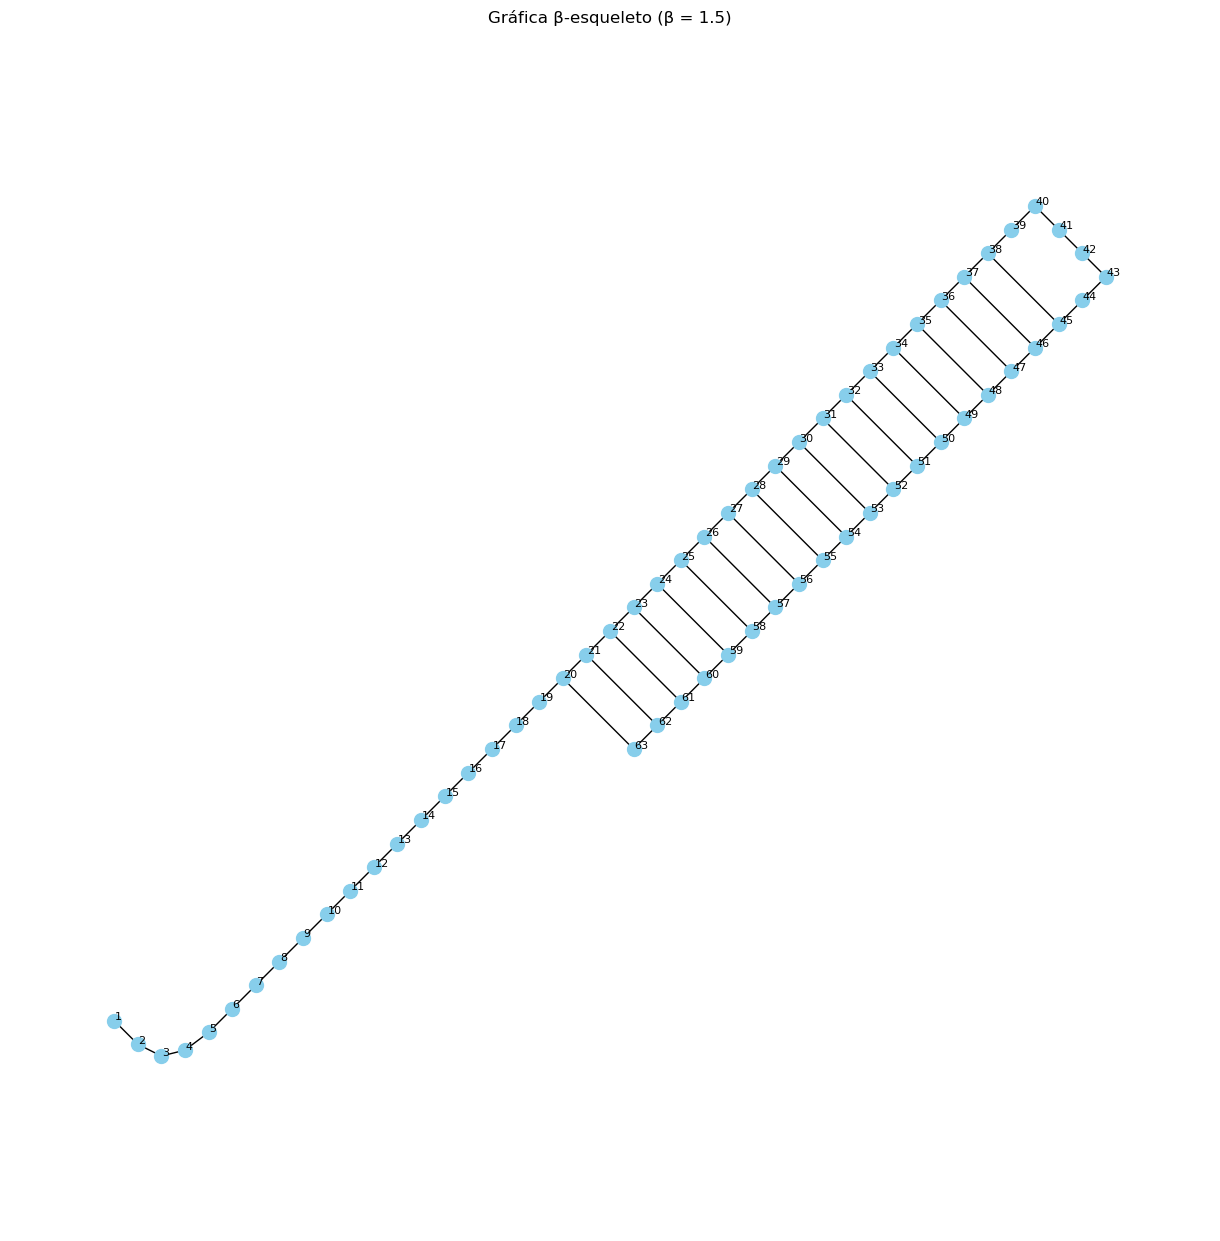

In [9]:
plot_beta_skeleton_graph(coords, names, beta=1.5)

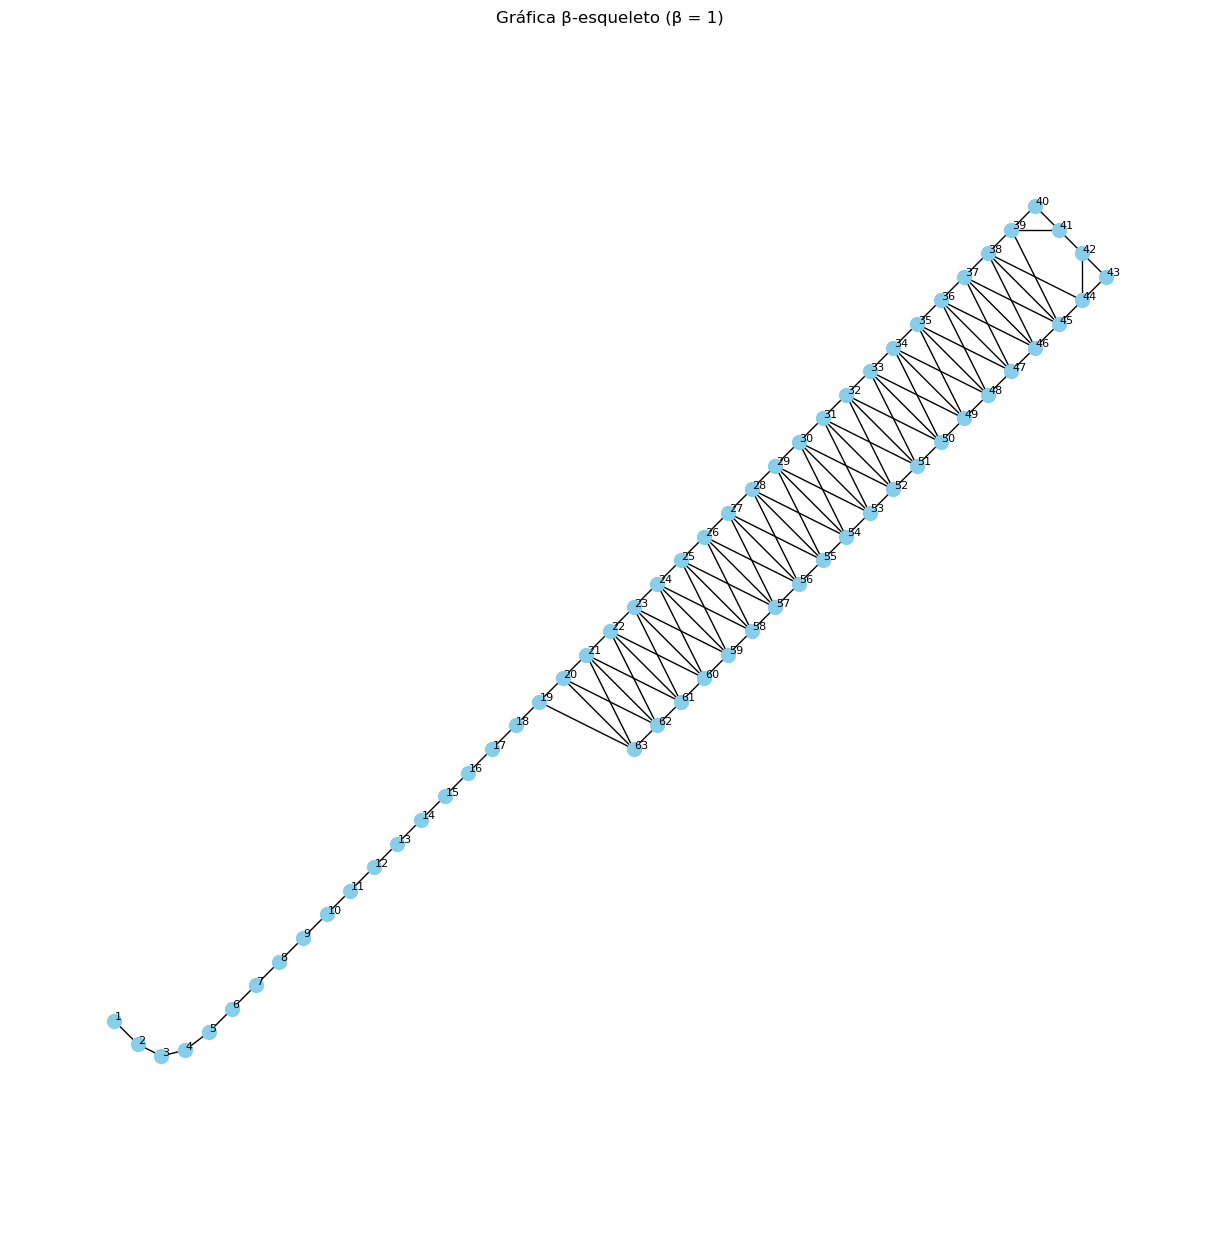

In [10]:
plot_beta_skeleton_graph(coords, names, beta=1)

In [11]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

# --- Inputs (from your df) ---
coords = df[["X", "Y"]].to_numpy()          # shape (n, 2)
names  = df["Dot Number"].to_numpy()        # shape (n,)

# --- Full pairwise Euclidean distance matrix ---
D = cdist(coords, coords, metric="euclidean")  # (n, n) symmetric, zeros on diagonal

# --- Compute MST ---
# Note: MST returns a sparse matrix with an arbitrary edge direction.
MST = minimum_spanning_tree(csr_matrix(D))

# --- Build a tidy edge list with names and weights ---
MST_coo = MST.tocoo()
edges_df = pd.DataFrame({
    "i": MST_coo.row,                       # row index in coords
    "j": MST_coo.col,                       # col index in coords
    "u": names[MST_coo.row],                # Dot Number at row
    "v": names[MST_coo.col],                # Dot Number at col
    "weight": MST_coo.data                  # Euclidean distance
}).sort_values("weight").reset_index(drop=True)

# Optional: total tree length and basic checks
total_length = edges_df["weight"].sum()
n = len(df)
assert len(edges_df) == n - 1, "MST on a connected set of n points should have n-1 edges."

print(edges_df)
print("Total MST length:", total_length)


     i   j   u   v     weight
0    2   3   3   4  20.615528
1    1   2   2   3  22.360680
2    3   4   4   5  25.000000
3    0   1   1   2  28.284271
4    4   5   5   6  28.284271
..  ..  ..  ..  ..        ...
57  57  58  58  59  28.284271
58  58  59  59  60  28.284271
59  59  60  60  61  28.284271
60  60  61  61  62  28.284271
61  61  62  62  63  28.284271

[62 rows x 5 columns]
Total MST length: 1736.7482115033386


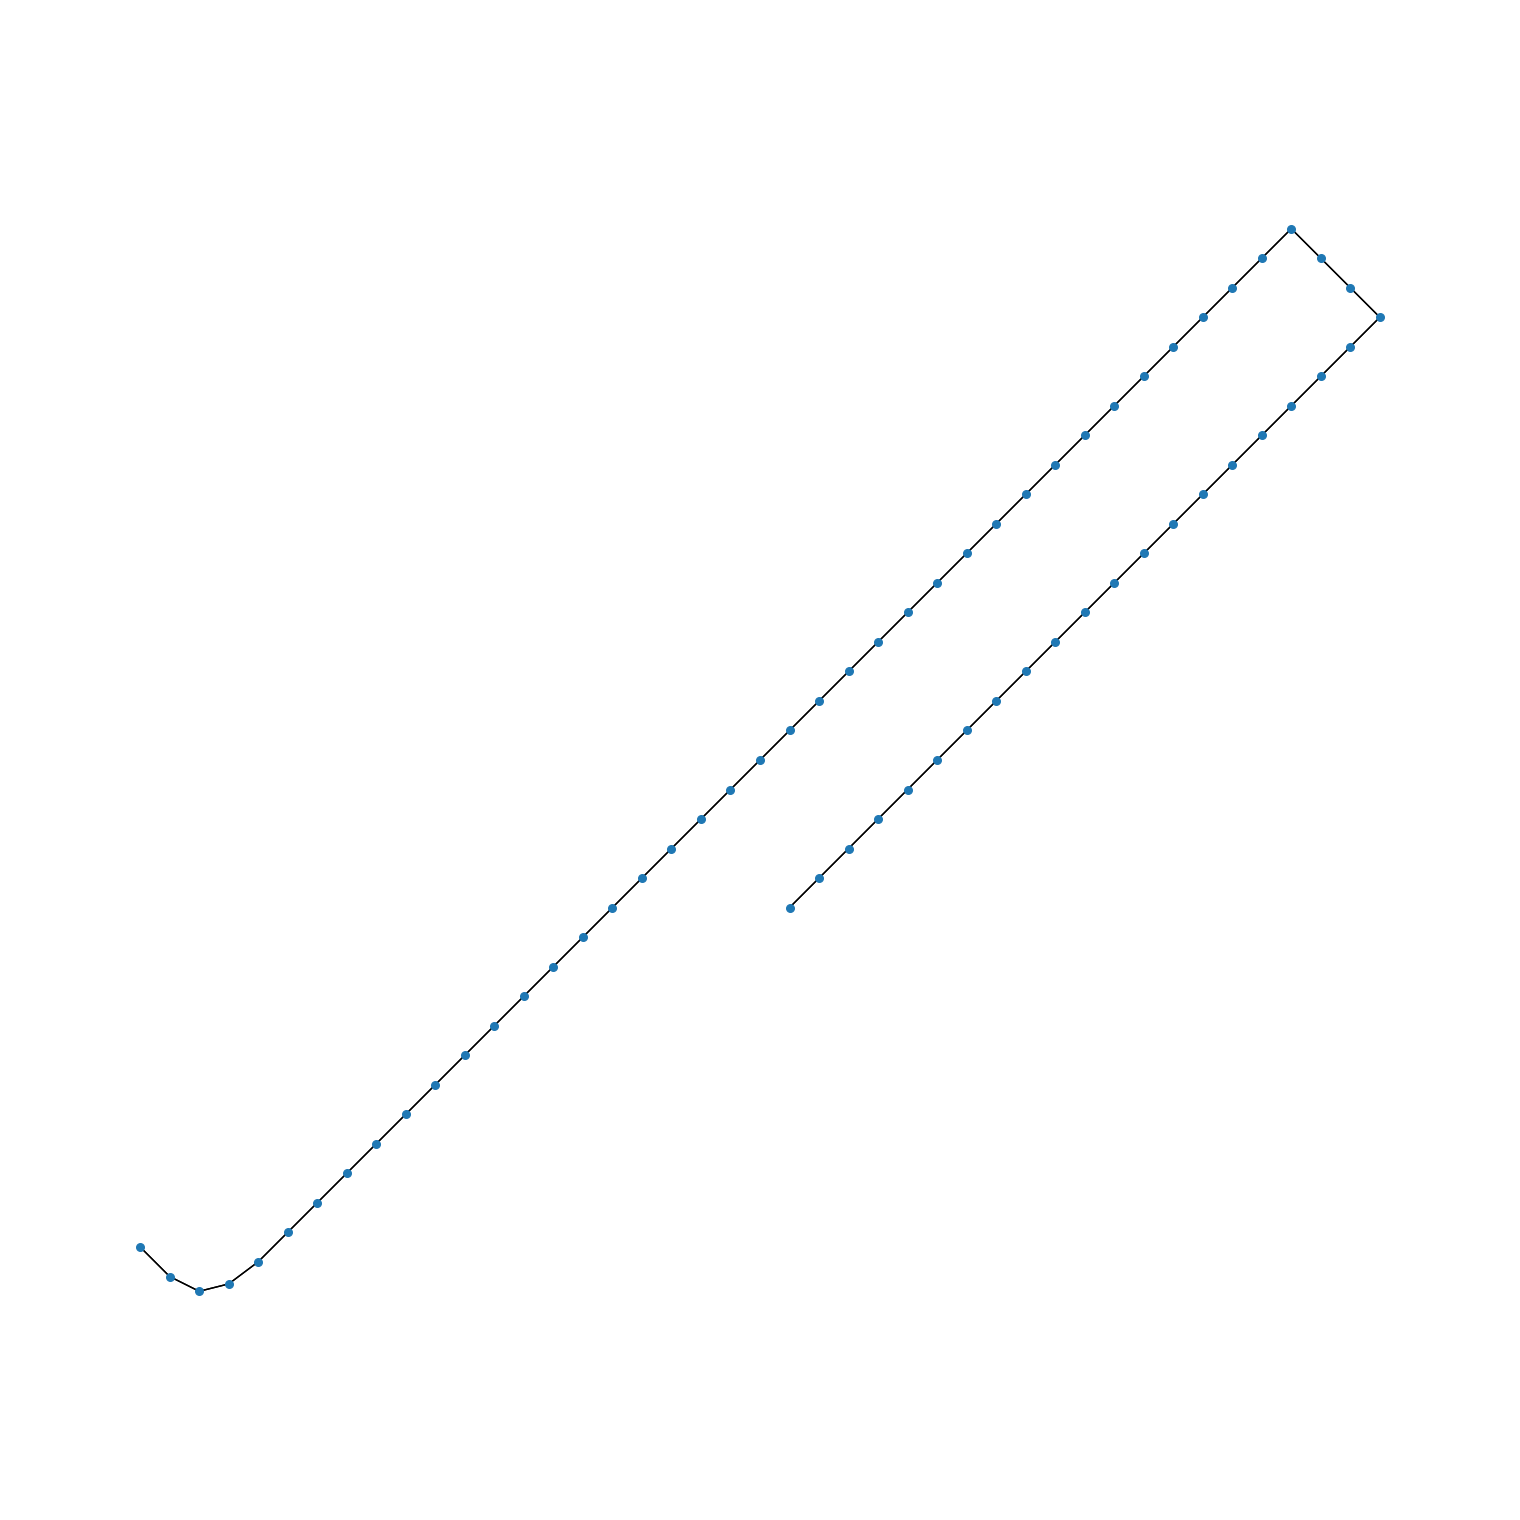

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for r, c, w in zip(MST_coo.row, MST_coo.col, MST_coo.data):
    G.add_edge(int(r), int(c), weight=float(w))

pos = {i: (coords[i, 0], coords[i, 1]) for i in range(coords.shape[0])}

plt.figure(figsize=(15, 15))
nx.draw(G, pos, with_labels=False, node_size=30)
nx.draw_networkx_edges(G, pos, width=1)
plt.axis("equal"); plt.show()
